# Detecting Quantum Dots


<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<a href="https://colab.research.google.com/github/DeepTrackAI/DeepLearningCrashCourse/blob/main/Ch05_UNet/ec05_A_qdots_localization/qdots_localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<strong>If using Colab/Kaggle:</strong> You need to uncomment the code in the cell below this one.
You need also to copy the "frame_with_qdots.tif" file from the
<a href="https://github.com/DeepTrackAI/DeepLearningCrashCourse/tree/main/Ch05_UNet/ec05_A_qdots_localization">notebook folder</a> in GitHub to the Colab/Kaggle work directory.
</div>

In [1]:
# !pip install deeplay deeptrack  # Uncomment if using Colab/Kaggle.

This notebook provides you with a complete code example that trains a U-Net to determine the positions of quantum dots in experimental images acquired with a fluorescence microscope.

<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<strong>Note:</strong> This notebook contains the Code Example 5-A from the book  

**Deep Learning Crash Course**  
Giovanni Volpe, Benjamin Midtvedt, Jesús Pineda, Henrik Klein Moberg, Harshith Bachimanchi, Joana B. Pereira, Carlo Manzo  
No Starch Press, San Francisco (CA), 2026  
ISBN-13: 9781718503922  

[https://nostarch.com/deep-learning-crash-course](https://nostarch.com/deep-learning-crash-course)

You can find the other notebooks on the [Deep Learning Crash Course GitHub page](https://github.com/DeepTrackAI/DeepLearningCrashCourse).
</div>

## Loading a Fluorescence Image of Quantum Dots

Load an image of quantum dot acquired with a fluorescence microscope (from a video of quantum dots labeling a membrane proteins in the membrane of living cells) ...

In [2]:
from PIL import Image

image_of_particles = Image.open("frame_with_qdots.tif")

... and plot it.

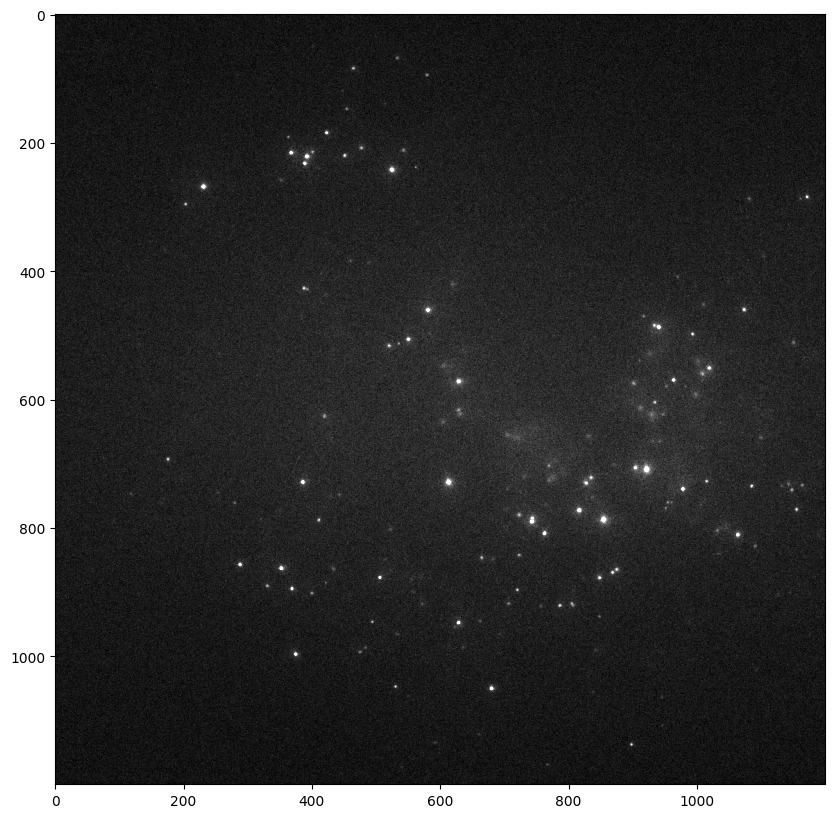

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(image_of_particles, vmin=100, vmax=200, cmap="gray")
plt.show()

## Cropping an Image of a Single Quantum Dot

Crop an image of a single quantum dot ...

In [4]:
x0, y0, crop_size = 178, 271, 50
crop = image_of_particles.crop((x0, y0, x0 + crop_size, y0 + crop_size))

... and plot it.

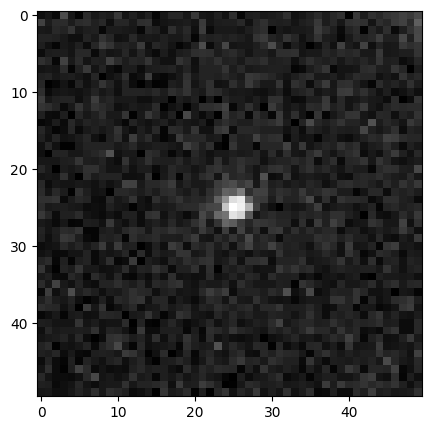

In [5]:
plt.figure(figsize=(5, 5))
plt.imshow(crop, vmin=100, vmax=200, cmap="gray")
plt.show()

## Simulating Images of Quantum Dots

### Simulating Images of a Single Quantum Dot

Define the simulation pipeline for the image of a single quantum dot ...

In [6]:
import deeptrack as dt
import numpy as np

optics = dt.Fluorescence(
    wavelength=600 * dt.units.nm, NA=0.9, magnification=1,
    resolution=0.1 * dt.units.um, output_region=(0, 0, 50, 50),
)
particle = dt.PointParticle(position=(25, 25), intensity=1.2e4, z=0)
sim_im_pip = optics(particle) >> dt.Add(30) >> np.random.poisson >> dt.Add(82)

... and compare between experimental and simulated images of quantum dots.

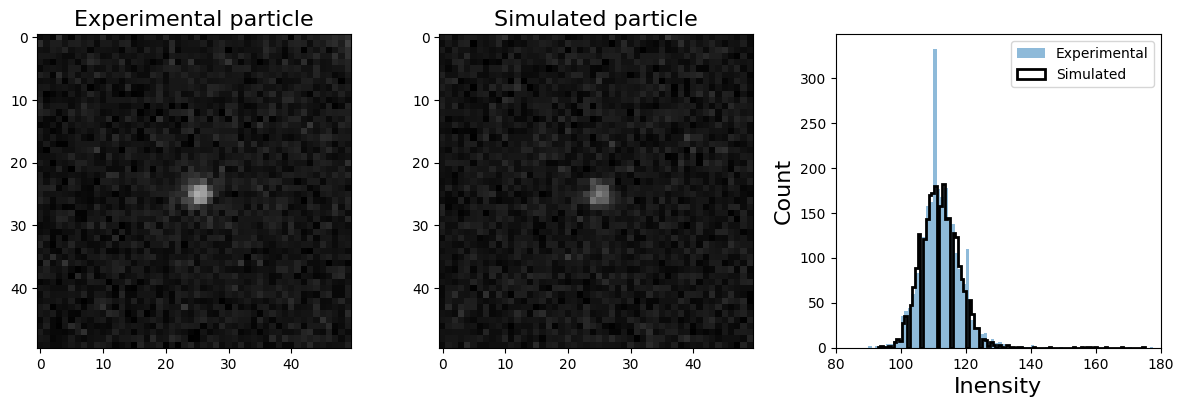

In [7]:
sim_im_pip.update()
sim_im = sim_im_pip()

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(crop, cmap="gray", vmin=100, vmax=250)
plt.title("Experimental particle", fontsize=16)

plt.subplot(1, 3, 2)
plt.imshow(sim_im, cmap="gray", vmin=100, vmax=250)
plt.title("Simulated particle", fontsize=16)

plt.subplot(1, 3, 3)
plt.hist(np.array(crop).flatten(), bins=100, label="Experimental", alpha=0.5)
plt.hist(np.array(sim_im).flatten(), bins=100, label="Simulated",
         histtype="step", color="black", linewidth=2)
plt.xlabel("Inensity", fontsize=16)
plt.xlim([80, 180])
plt.ylabel("Count", fontsize=16)
plt.legend()

plt.tight_layout()
plt.show()

### Simulating Images with Multiple Quantum Dots

Update the simulation pipeline to create images of multiple quantum dots ...

In [8]:
optics = dt.Fluorescence(
    wavelength=600 * dt.units.nm, NA=0.9, magnification=1,
    resolution=0.1 * dt.units.um, output_region=(0, 0, 128, 128),
)
particle = dt.PointParticle(
    position=lambda: np.random.uniform(0, 128, size=2),
    intensity=lambda: np.random.uniform(6e3, 3e4),
    z=lambda: np.random.uniform(-1.5, 1.5) * dt.units.um,
)
postprocess = (dt.Add(lambda: np.random.uniform(20, 40)) >> np.random.poisson
               >> dt.Add(lambda: np.random.uniform(70, 90)))
normalization = dt.AsType("float") >> dt.Subtract(110) >> dt.Divide(250)
particles = particle ^ (lambda: np.random.randint(10, 20))
sim_im_pip = optics(particles) >> postprocess >> normalization

... define the simulation pipeline for the output mask ...

In [9]:
sim_mask_pip = (particles
                >> dt.SampleToMasks(lambda: lambda particle: particle > 0,
                                    output_region=optics.output_region,
                                    merge_method="or")
                >> dt.AsType("int") >> dt.OneHot(num_classes=2))

... combine the pipelines for the quantum dot image and the ground truth
mask ...

In [10]:
import torch

sim_im_mask_pip = ((sim_im_pip & sim_mask_pip) >> dt.MoveAxis(2, 0)
                   >> dt.pytorch.ToTensor(dtype=torch.float))

... and plot the simulated image and corresponding ground truth mask.

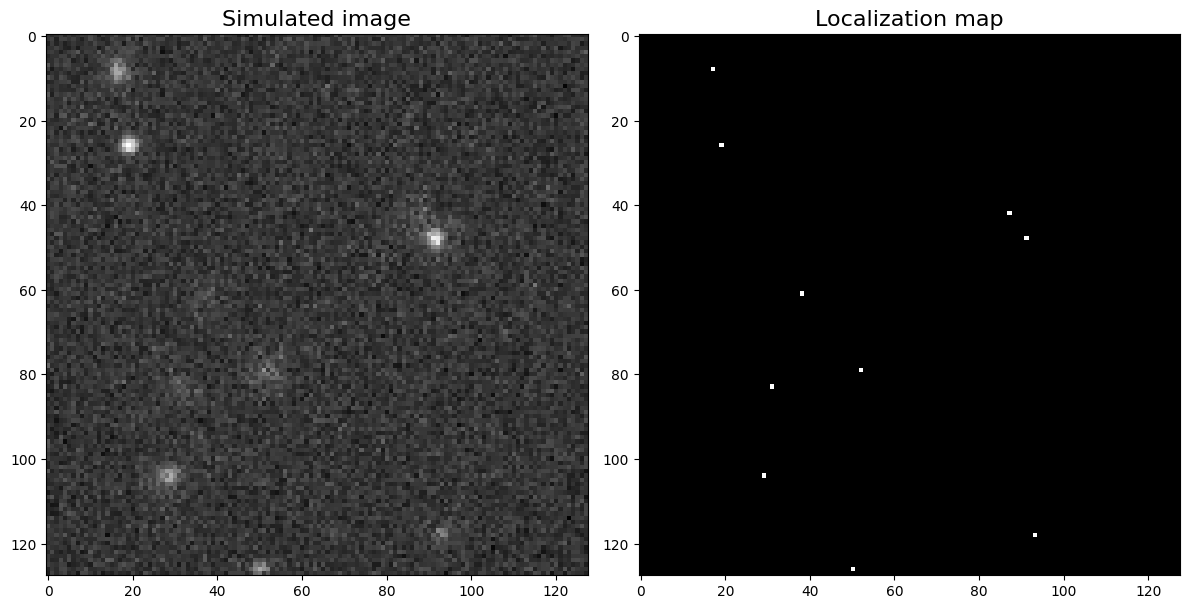

In [11]:
sim_im, sim_mask = sim_im_mask_pip.update().resolve()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(sim_im.squeeze(), cmap="gray")
plt.title("Simulated image", fontsize=16)

plt.subplot(1, 2, 2)
plt.imshow(sim_mask[1], cmap="gray")
plt.title("Localization map", fontsize=16)

plt.tight_layout()
plt.show()

## Defining and Training the U-Net

Define the U-Net ...

In [12]:
import deeplay as dl

unet = dl.UNet2d(in_channels=1, channels=[32, 64], out_channels=2)

print(unet)

UNet2d(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Layer[Conv2d](in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
      (1): Conv2dBlock(
        (pool): Layer[MaxPool2d](kernel_size=2, stride=2)
        (layer): Layer[Conv2d](in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
    )
    (postprocess): Layer[Identity]()
  )
  (bottleneck): ConvolutionalNeuralNetwork(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (pool): Layer[MaxPool2d](kernel_size=2, stride=2)
        (layer): Layer[Conv2d](in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (upsample): Layer[ConvTranspose2d](kernel_size=2, stride=2, padding=0, in_channels=64, out_channels=64)
      )
    )
  )
  (decoder): ConvolutionalDecoder2d(
    (blocks): LayerList(
      (0): 

... compile it for the task of regressing the masks from the images ...

In [13]:
unet_reg = dl.Regressor(
    model=unet, loss=torch.nn.CrossEntropyLoss(weight=torch.tensor([1, 10])),
    optimizer=dl.Adam(),
).create()

print(unet_reg)

Regressor(
  (loss): CrossEntropyLoss()
  (optimizer): Adam[Adam]()
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): UNet2d(
    (encoder): ConvolutionalEncoder2d(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (layer): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (1): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
      )
      (postprocess): Identity()
    )
    (bottleneck): ConvolutionalNeuralNetwork(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(64, 64, kernel_size

... and train it.

In [14]:
train_dataset = dt.pytorch.Dataset(sim_im_mask_pip, length=320, replace=.1)
data_loader = dl.DataLoader(train_dataset, batch_size=32)
unet_trainer = dl.Trainer(max_epochs=50, accelerator="auto")
unet_trainer.fit(unet_reg, data_loader)

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | tra

Training: |          | 0/? [00:00<?, ?it/s]

## Applying the Trained U-Net to Experimental Data

Implement a function to convert a binary mask into an array of centroid positions ...

In [15]:
import skimage as sk

def mask_to_positions(mask):
    """Convert binary mask to centroid array."""
    labels = sk.measure.label(mask)
    props = sk.measure.regionprops(labels)
    return np.array([prop.centroid for prop in props])

... and apply the trained U-Net to an experimental image.

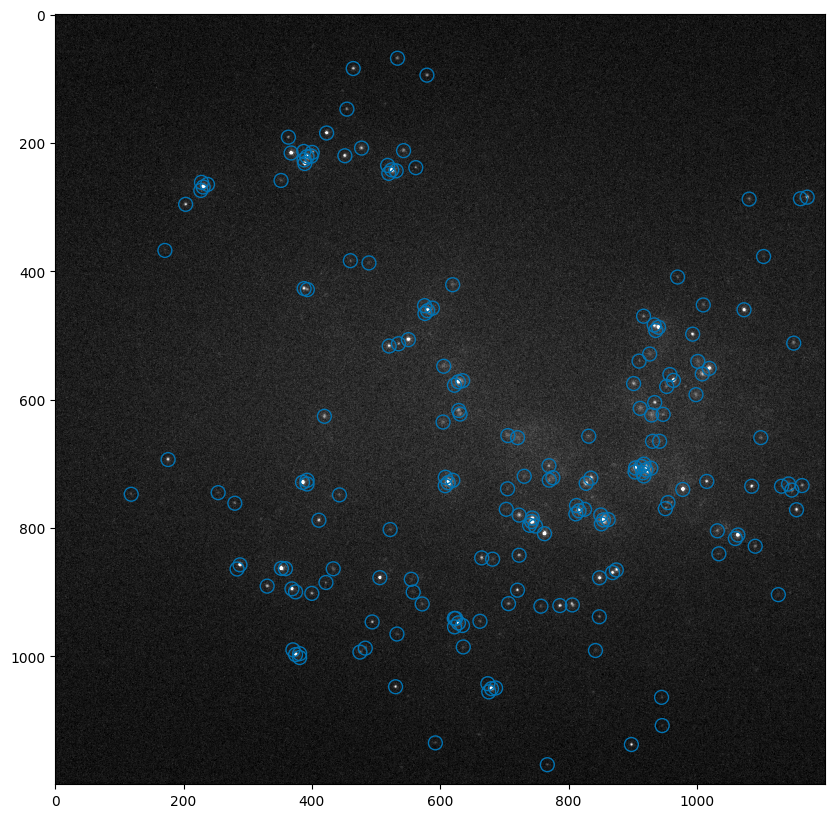

In [16]:
image_of_particles_tensor = torch.from_numpy(
    (np.array(image_of_particles).astype(np.float32) - 110) / 250
).unsqueeze(0)

pred_mask = unet_reg(image_of_particles_tensor.unsqueeze(0)).detach()
pred_mask = torch.nn.functional.softmax(pred_mask, dim=1)
positions = mask_to_positions(pred_mask[0, 1, ...] > 0.5)

plt.figure(figsize=(10, 10))
plt.imshow(image_of_particles, vmin=100, vmax=200, cmap="gray")
plt.scatter(positions[:, 1], positions[:, 0], s=100, facecolors="none",
            edgecolors=(0.0039, 0.45, 0.70))
plt.show()